In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate, optimize, special
from datetime import timedelta
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [2]:
df = pd.read_pickle("../data/df.pickle")
df = df.dropna()

In [3]:
df_lockdown = df[(df["started_at"] >= "2020-03-21") & (df["started_at"] < "2020-06-01")].dropna()
df_resi1 = df[(df["started_at"] >= "2020-06-01") & (df["started_at"] < "2020-11-01")].dropna()
df_resi2 = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-11-16")].dropna()
df_2020_nov = df[(df["started_at"] >= "2020-11-01") & (df["started_at"] < "2020-12-01")].dropna()
df_lockdown_relax = df[(df["started_at"] >= "2020-11-16") & (df["started_at"] < "2020-12-17")].dropna()
df_after_lockdown = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2023-10-01")].dropna()
df_aft_eto = df[(df["started_at"] >= "2020-12-17") & (df["started_at"] < "2021-02-23")].dropna()

In [14]:
def Model3(M):

    def obj(a,i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)

    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i), limit=5000)[0]

    N = Np*(1 - vals)
    return N

def kappa(M, Np):
    return ((alpha+beta)/alpha)**2*2*M/Np/(Np-1)

In [15]:
def Model3_fixed(M, alpha, beta):
    def obj(a, i):
        f = lambda a: a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)
        return f(a)*( 1-((alpha+beta)/alpha)*2*M[i]*a/Np/(Np-1) )**(Np-1)
    vals = np.zeros(len(M))
    for i in range(len(M)):
        vals[i] = integrate.quad(obj, 0,1, args=(i))[0]
    
    N = Np*(1 - vals)
    return N 

In [6]:
def return_nm(df):
    df['started_at'] = pd.to_datetime(df['started_at'])
    df['ended_at'] = pd.to_datetime(df['ended_at'])
    # started_atで昇順にソート
    df = df.sort_values(by='start_station_name')
    current_timestamp = df['started_at'].min()
    end_timestamp = df["started_at"].max()
    interval = timedelta(days=1)

    node_list = []
    edge_list = []
    timestamp = []

    while current_timestamp <= end_timestamp:
        timestamp.append(current_timestamp)
        next_timestamp = current_timestamp + interval
        df_tmp = df[(df['started_at'] >= current_timestamp) & (df['started_at'] < next_timestamp)]
        # start_station_nameをリスト化
        start_station_name = df_tmp["start_station_name"].unique()

        # 各駅について、IDを割り振る
        station_id = {}
        for i, station in enumerate(start_station_name):
            station_id[station] = i
        
        # station_idを元に、df_lockdown_relax_2020_11にstation_idを追加
        df_tmp["station_id"] = df_tmp["start_station_name"].map(station_id)

        # ノードの数を取得
        node_list.append(len(station_id))

        # エッジの数を取得
        edge_list.append(len(df_tmp))
        
        current_timestamp = next_timestamp


    # node_listとedge_listで0の値を削除
    
    return node_list, edge_list

In [17]:
def rho(a, alpha, beta):
    return a**(alpha-1)*(1-a)**(beta-1)/special.beta(alpha, beta)

In [26]:
alpha_list = [0.471, 0.352, 0.081, 0.447, 0.205, 0.115, 0.116]
beta_list = [9.707, 5.342, 0.819, 25.649, 4.351, 8.175, 7.791]
label_list = ["Lockdown", "2020/6/1~2020/10/31", "2020/11/1~2020/11/30", "2020/12/1~2020/12/31", "2021/1/1~2021/12/31", "2022/1/1~2022/12/31", "2023/1/1~2023/9/30"]

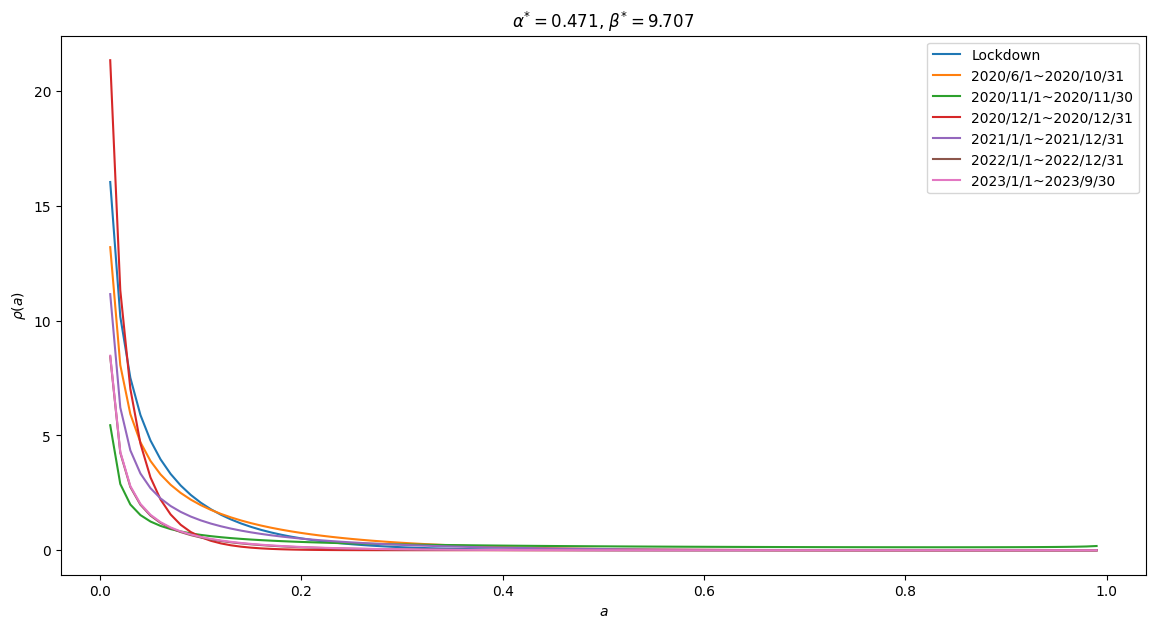

In [31]:
a = np.arange(0, 1, 0.01)
plt.figure(figsize=(14,7))
plt.plot(a, rho(a, alpha_list[0], beta_list[0]), label=label_list[0])
plt.plot(a, rho(a, alpha_list[1], beta_list[1]), label=label_list[1])
plt.plot(a, rho(a, alpha_list[2], beta_list[2]), label=label_list[2])
plt.plot(a, rho(a, alpha_list[3], beta_list[3]), label=label_list[3])
plt.plot(a, rho(a, alpha_list[4], beta_list[4]), label=label_list[4])
plt.plot(a, rho(a, alpha_list[5], beta_list[5]), label=label_list[5])
plt.plot(a, rho(a, alpha_list[6], beta_list[6]), label=label_list[6])


plt.xlabel(r"$a$")
plt.ylabel(r"$\rho(a)$")
plt.title(r"$\alpha^{*}=$"+str(round(alpha_list[0], 3))+r", $\beta^{*}=$"+str(round(beta_list[0], 3)))
plt.legend()
plt.show()

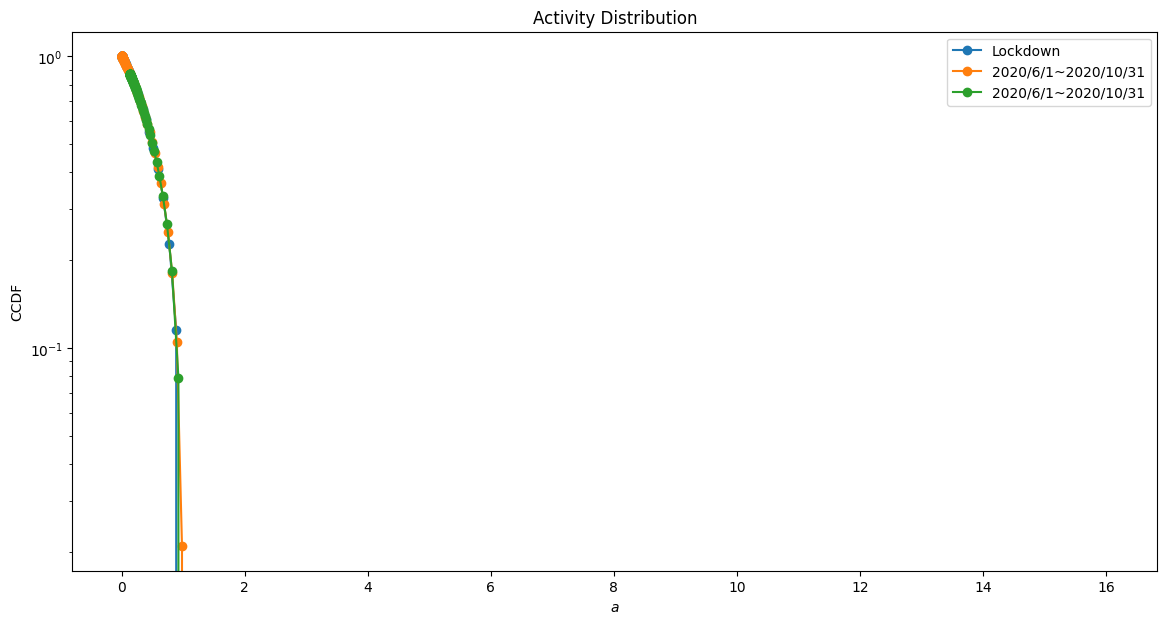

In [39]:
# ccdf
plt.figure(figsize=(14,7))
rho_list = []
for i in range(len(a)):
    rho_list.append(rho(a[i], alpha_list[0], beta_list[0]))

sorted_rho_list = sorted(rho_list)
ccdf = []
for i in range(len(sorted_rho_list)):
    ccdf.append(1-sorted_rho_list[i])
plt.semilogy(sorted_rho_list, ccdf, label=label_list[0], linestyle="solid", marker="o")

rho_list = []
for i in range(len(a)):
    rho_list.append(rho(a[i], alpha_list[1], beta_list[1]))

sorted_rho_list = sorted(rho_list)
ccdf = []
for i in range(len(sorted_rho_list)):
    ccdf.append(1-sorted_rho_list[i])
plt.semilogy(sorted_rho_list, ccdf, label=label_list[1], linestyle="solid", marker="o")

rho_list = []
for i in range(len(a)):
    rho_list.append(rho(a[i], alpha_list[2], beta_list[2]))

sorted_rho_list = sorted(rho_list)
ccdf = []
for i in range(len(sorted_rho_list)):
    ccdf.append(1-sorted_rho_list[i])
plt.semilogy(sorted_rho_list, ccdf, label=label_list[1], linestyle="solid", marker="o")

plt.xlabel(r"$a$")
plt.ylabel(r"CCDF")
plt.title(r"Activity Distribution")
plt.legend()
plt.show()


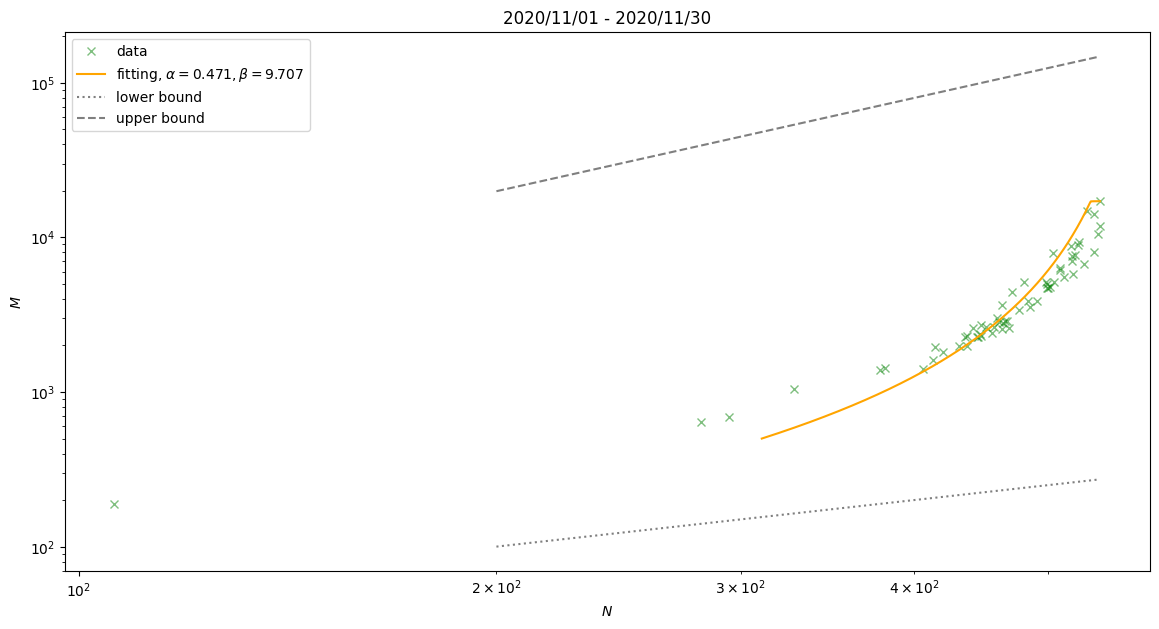

In [16]:
node, edge = return_nm(df_lockdown)

plt.figure(figsize=(14,7))

N = node
M = edge
Np = 596 # histrical dataから求めたNp

x = np.arange(200, np.max(N))
y = np.arange(500, np.max(M))


plt.plot(N, M, "x", c="green", alpha=0.5, label="data")

params, _ = optimize.curve_fit(Model3_fixed, edge, node, p0=[0.6, 1])
alpha = params[0]
beta = params[1]

plt.plot(Model3(y), y, "-", c="orange", label=f"fitting, $\\alpha={round(alpha, 3)}, \\beta={round(beta, 3)}$")

plt.plot(x,x/2, label="lower bound", c = "black", alpha= 0.5, ls = ":")
plt.plot(x,x*(x-1)/2, label="upper bound", c = "black", alpha = 0.5, ls = "--")
#plt.text(0.05, 0.65, r'$\hat{\kappa}:$ ' + str(round(kappa, 3)), transform=plt.gca().transAxes)
plt.xscale("log")
plt.yscale("log")
plt.title("2020/11/01 - 2020/11/30")
plt.xlabel(r"$N$")
plt.ylabel(r"$M$")
plt.legend()
plt.show()